In [1]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])

/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/lib/_distopia.py:45: RuntimeWarning: Install 'distopia>=0.2.0,<0.3.0' to be used with this release of MDAnalysis. Your installed version of distopia >=0.3.0 will NOT be used.
  warnings.warn(


## RMSD Calculation

In [2]:
#Read all the trajectories
colpm_pyc= mda.Universe('colpm_pyc_complex/sys_prod/start.pdb', 'colpm_pyc_complex/sys_prod/prod_colpm_pyc_complex_compact_compact.xtc')


/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/topology/PDBParser.py:346: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn(wmsg)
/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/coordinates/XDR.py:253: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn(


  0%|          | 0/10001 [00:00<?, ?it/s]

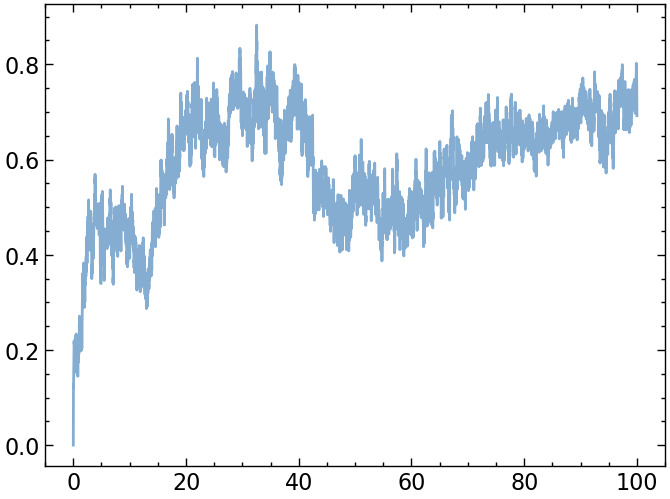

In [3]:
from MDAnalysis.analysis import rms

R = rms.RMSD(colpm_pyc,  # universe to align
    colpm_pyc,  # reference universe or atomgroup
    select='backbone',  # group to superimpose and calculate RMSD
    ref_frame=0)  # frame index of the reference

R.run(verbose=True)
times_c = R.results.rmsd[:,1]
rmsd_c = R.results.rmsd[:,2]
plt.plot(times_c/1000, rmsd_c/10, alpha=0.5)

## Radius of Gyration Calculation

  0%|          | 0/10001 [00:00<?, ?it/s]

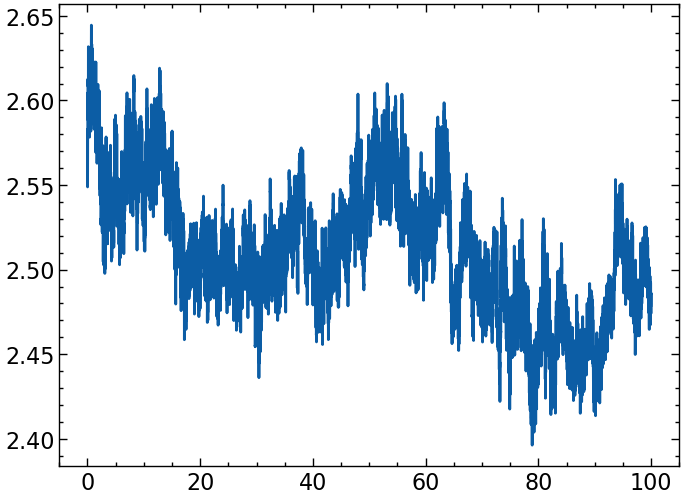

In [4]:
from tqdm.notebook import tqdm
group = colpm_pyc.select_atoms('protein')		# change the atom selection for your specific system

Frame = []
times = []
Rgyr = []
for ts in tqdm(colpm_pyc.trajectory):
	Frame.append(ts.frame)
	times.append(colpm_pyc.trajectory.time)
	Rgyr.append(group.radius_of_gyration())

Rgyrc_table = np.vstack((Frame, times, Rgyr)).T
plt.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10)

## RMSF Calculation

Between protein backbone and Carbon alphas.

  0%|          | 0/10001 [00:00<?, ?it/s]

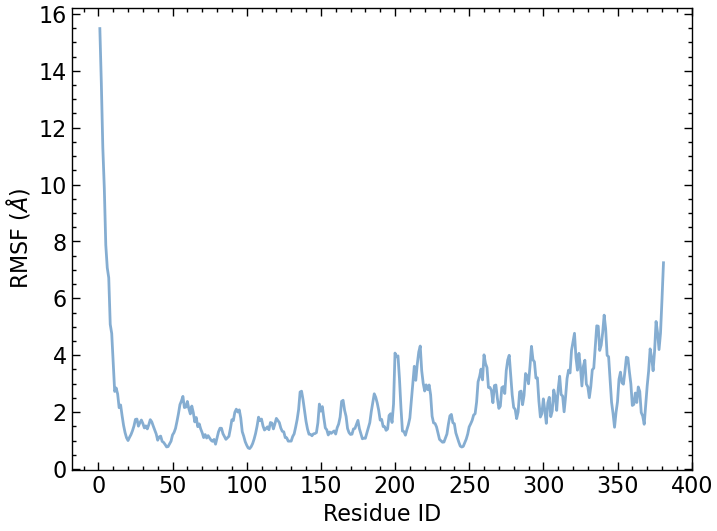

In [67]:
c_alphas_c = colpm_pyc.select_atoms('backbone and name CA')
R_c = rms.RMSF(c_alphas_c).run(verbose=True)
plt.xlabel('Residue ID')
plt.ylabel(r'RMSF $\left(\AA\right)$')
plt.plot(c_alphas_c.resids, R_c.results.rmsf, alpha=0.5)
plt.savefig('rmsf.png', dpi=600)

### Observations

Rapid changes in radius of gyration, together with high RMSF in the first few residues of the protein suggest conformational changes in the tail end of the chain. Might need `DSSP` for further analysis.

## H-bond analysis:

**Note:** As of today (20241222), the latest version of MDAnalysis (2.8) cannot read binary topology files (the ones with the `.tpr` extension) created by gromacs version 2024.4. Binary topology data is necessary for hydrogen bond analysis in `MDAnalysis` for some reason, so I am trying `MDTraj` instead.


In `MDTraj`, the Baker-Hubbard Hydrogen Bond Identification can be used, where the hydrogen bond is said to have formed if:

1. The angle $\theta_{dha}>2\pi/3$, *i.e.*, $120$ degrees, and
2. The distance $r_{ha}<0.25\;nm$. 
   
Here, $d$ means 'donor', 'h' means 'hydrogen', and 'a' means acceptor.
The donors considered by this method are NH and OH, and the acceptors considered are O and N.

Do not load the whole trajectory, as it will take up too much memory. Unlike `MDAnalysis`, `MDTraj` doesn't do lazy loads from disk, but fully operates in memory. This makes it faster, but memory-intensive.

So, we choose a 'stride' of, say, $60$ frames, and have `MDTraj` load every $60^{th}$ frame of the trajectory, then run the baker-hubbard algorithm.

Actually, it is better to load the full trajectory in hpc and pickle the results to be used locally later.

In [1]:
import numpy as np
stride = 6
total_frames = 10000
total_time_ns = 100

timestep  = (stride/total_frames) * total_time_ns

nframes = int(np.ceil(total_frames/stride))

timestep, nframes

(0.06, 1667)

In [2]:
import numpy as np
import mdtraj as md

topfile='colpm_pyc_complex/sys_prod/start.pdb'
xtcfile='colpm_pyc_complex/sys_prod/prod_colpm_pyc_complex_compact_compact.xtc'

full_traj = md.load_xtc(xtcfile, stride=stride, top=topfile)
pyc_atoms = full_traj.topology.select('resname PYC')
hbonds = md.baker_hubbard(full_traj, periodic=False, freq=0.01)
label = lambda hbond : '%s - %s ... %s' % ( full_traj.topology.atom(hbond[0]),\
                                            full_traj.topology.atom(hbond[1]),\
                                            full_traj.topology.atom(hbond[2]))
pyc_hbonds = []
for hbond in hbonds:
    d,h,a = hbond
    if d in pyc_atoms or a in pyc_atoms:
        pyc_hbonds.append(hbond)
        print(label(hbond))

pyc_hbonds = np.array(pyc_hbonds)

ASN174-N - ASN174-H ... PYC382-O
ASN174-N - ASN174-H ... PYC382-N1
THR177-OG1 - THR177-HG1 ... PYC382-O


So, according to `MDTraj` Baker-Hubbard hbond detector, there are **THREE** hydrogen bond between protein and PYC that forms at more than a frequency of `freq=` $0.01$ in the trajectory frames. 

However, these bond are highly intermittent, as can be seen in the number of bonds plot below.

Calculate the distances and angles for each hbond.

In [3]:
da_distances = md.compute_distances(full_traj, pyc_hbonds[:, [1,2]], periodic=False)
da_angles = md.compute_angles(full_traj, pyc_hbonds, periodic=False)

Let us get the number of hbonds between protein and ligand.

In [4]:
distance_met = da_distances < 0.25
angle_met = da_angles > 2 * np.pi/3
hbond_met = np.logical_and(distance_met, angle_met)
num_hbonds = np.sum(hbond_met, axis=1)

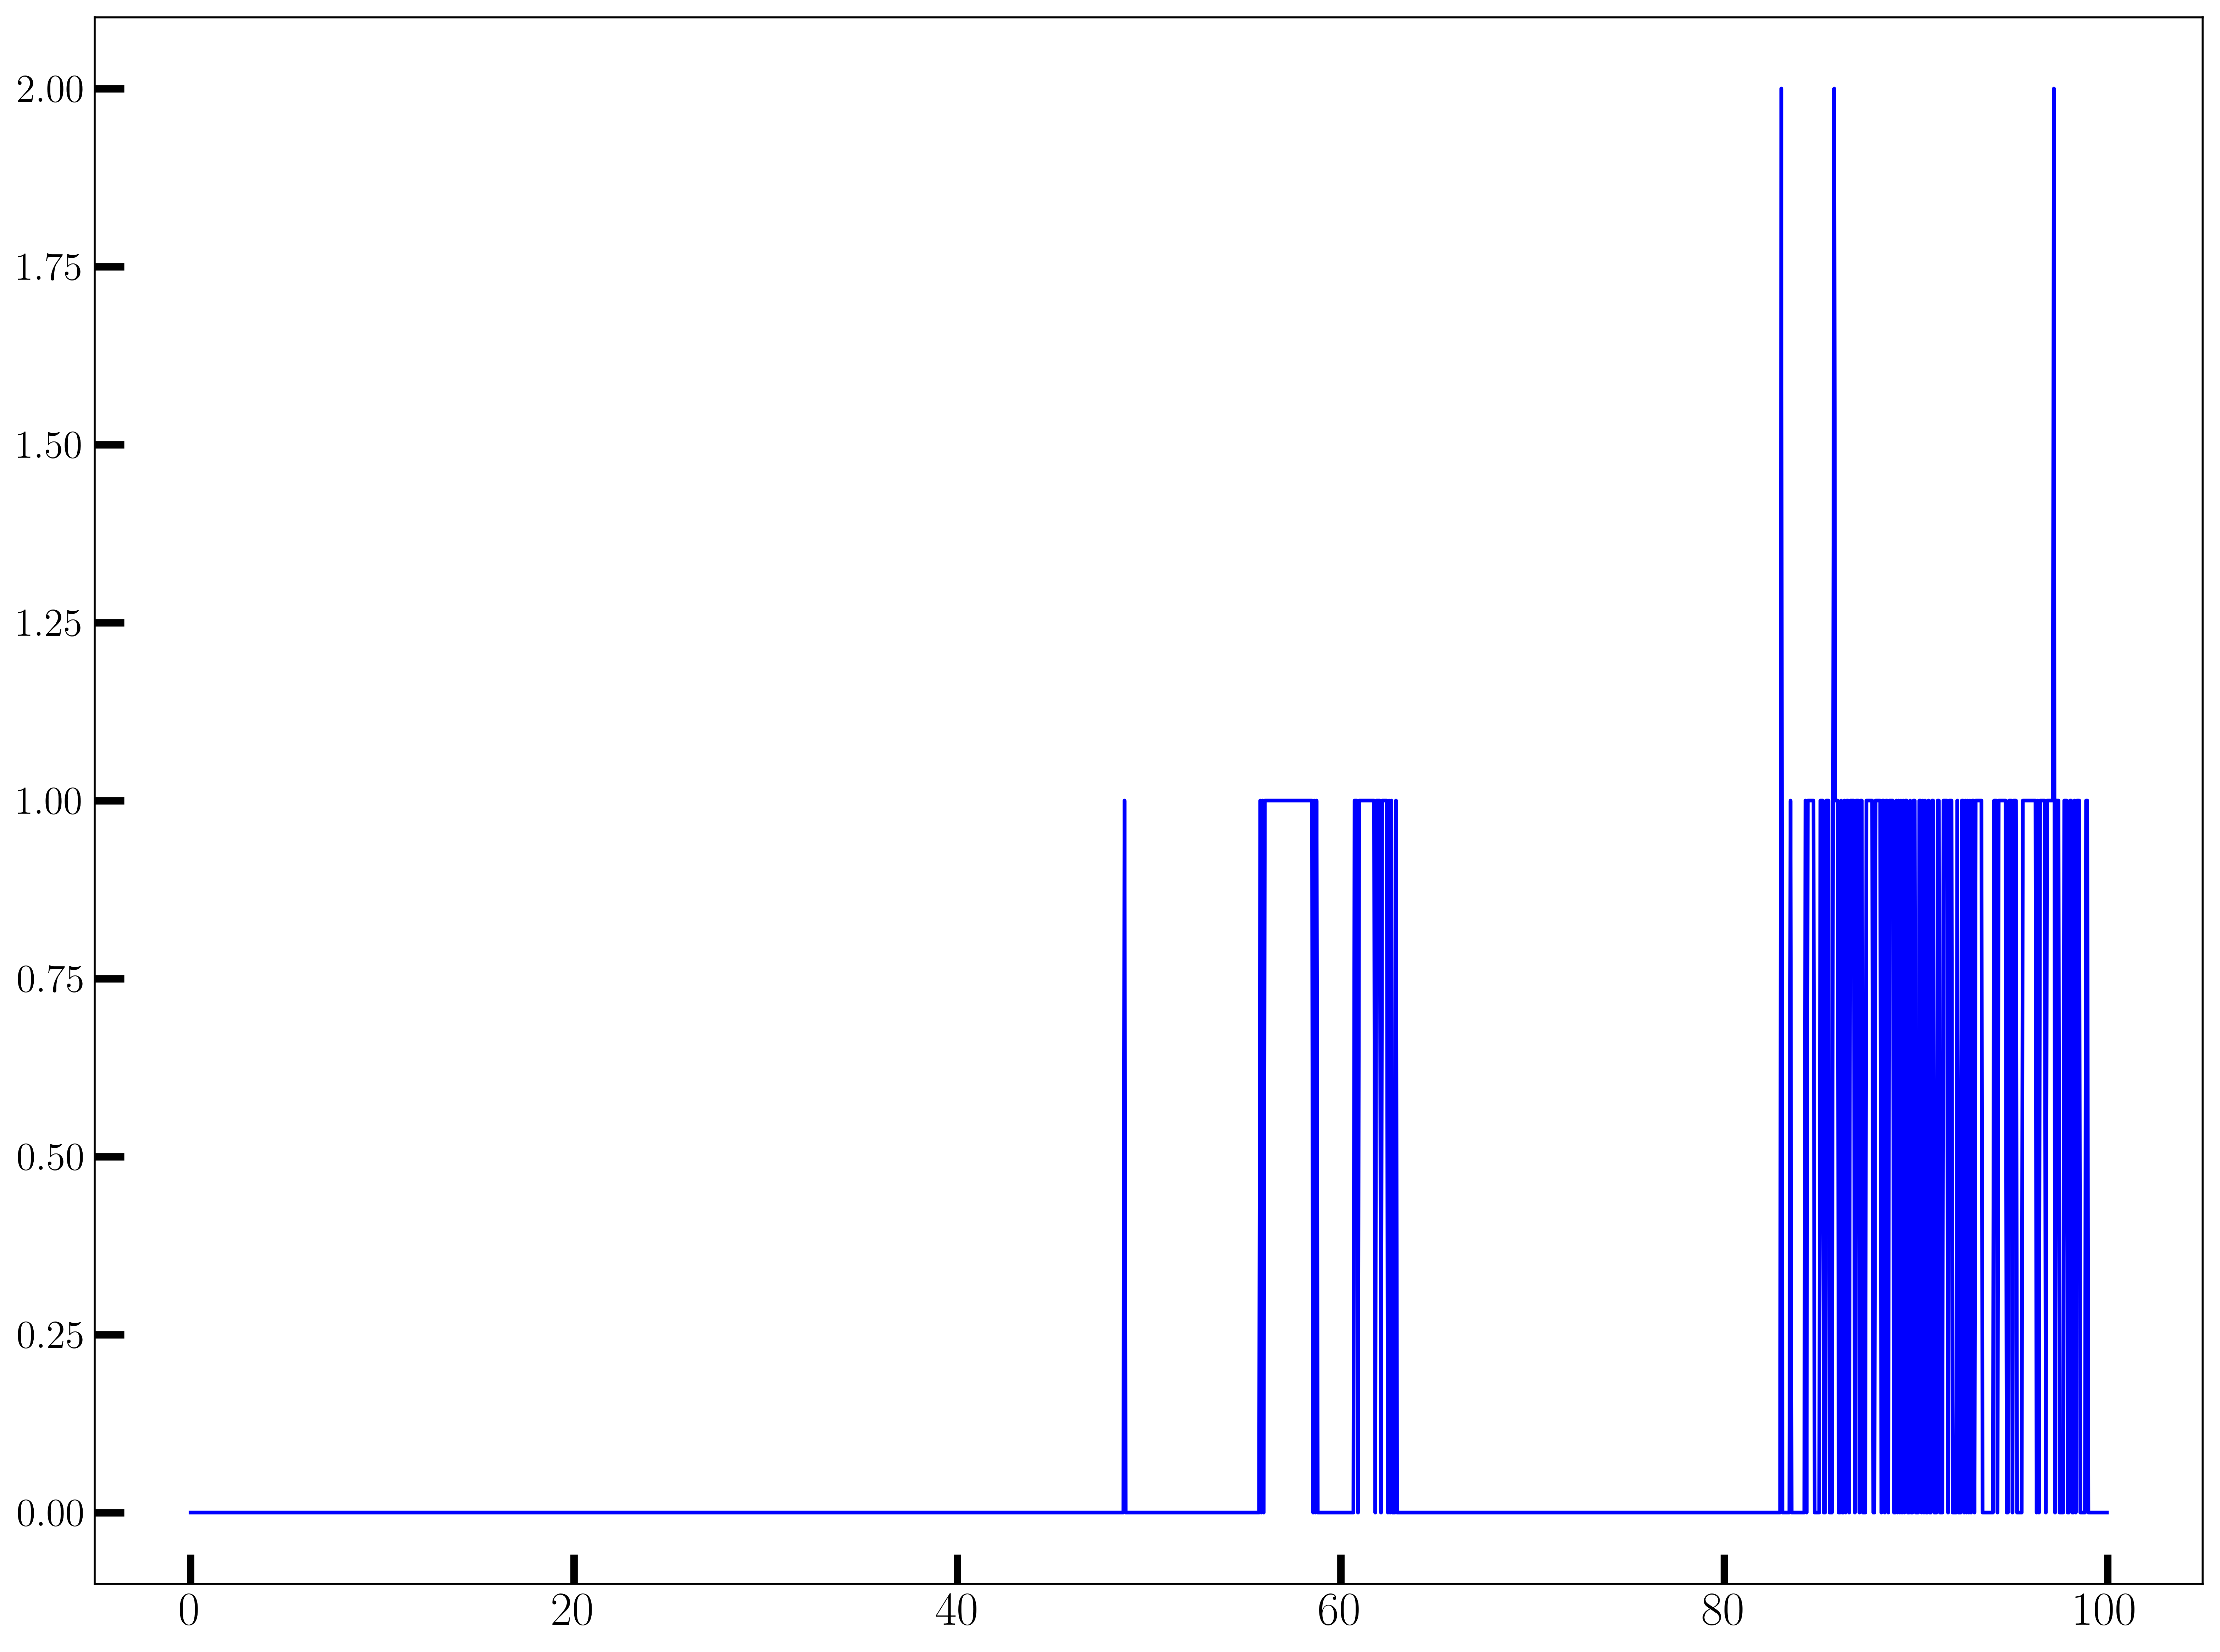

In [5]:
import matplotlib.pyplot as plt
plt.plot(full_traj.time/1000, num_hbonds,'b-')
np.savez('colpm_pyc_nhb.npz', time=full_traj.time/1000, num_hbonds=num_hbonds)

Highly intermittent bonds.

## Hydrogen Bond lifetimes via correlation analysis

For the h-bond, we plot 

\begin{equation*}
C^{ij}_x(t)=\left\langle\frac{h_{i j}\left(t_0\right) h_{i j}\left(t_0+t\right)}{h_{i j}\left(t_0\right)^2}\right\rangle_{t_0}
\end{equation*}

where 

\begin{equation*}
h_{ij} = \begin{cases}
1 & \text{If hbond: } i \to j\\
0 & \text{otherwise }
\end{cases}
\end{equation*}

The subscript in $C_x$, $x$, can be either $C$ (continuous) or $I$ (intermittent). When $x=C$, a bond, once broken, is assumed to never form again even if conditions are optimal, whereas when $x=I$, bond formation is counted regardless of history. Thus, a low $C_C(t)$ and high $C_I(t)$ indicates the dominance of intermittent hydrogen bonds. The curves are fit to exponential decays to yield bond life times.


First, get the donor, hydrogen and acceptor ids obtained my `mdtraj`  into the `mdanalysis` hydrogen bond analysis tool.

In [12]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
#d_ix, h_ix, a_ix = pyc_hbonds.flatten()

#Giving full tpr file to include bonding info
u = mda.Universe("colpm_pyc_complex/sys_prod/prod_colpm_pyc_complex.tpr",\
            "colpm_pyc_complex/sys_prod/prod_colpm_pyc_complex_compact_compact.xtc")

In [13]:
mda_hbonds = []

for hbond in pyc_hbonds:
    d_ix, h_ix, a_ix = hbond
    mda_hbonds.append(HBA(
        universe=u,
        donors_sel=f"index {d_ix}",
        hydrogens_sel=f"index {h_ix}",
        acceptors_sel=f"index {a_ix}",
        update_selections=False
    ).run(verbose=True))

  0%|          | 0/10001 [00:00<?, ?it/s]

/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:742: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, index 2595, and Acceptor, index 5795.
  warnings.warn(
/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, index 2595, and Acceptor, index 5795.
  warnings.warn(


  0%|          | 0/10001 [00:00<?, ?it/s]

/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:742: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, index 2595, and Acceptor, index 5797.
  warnings.warn(
/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, index 2595, and Acceptor, index 5797.
  warnings.warn(


  0%|          | 0/10001 [00:00<?, ?it/s]

/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:742: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, index 2645, and Acceptor, index 5795.
  warnings.warn(
/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, index 2645, and Acceptor, index 5795.
  warnings.warn(


Then, run the lifetime analysis

Finally, we can estimate the lifetime by fitting to exponential function (see references below)

\begin{equation*}
C_I(t) = A_1 e^{-t/\tau_1} + A_2 e^{-t/\tau_2} + \left(1-A_1 - A_2\right) e^{-t/\tau_3}
\end{equation*}

Here, the last term is said to contribute to the intermittent nature of the hydrogen bonds. The bond lifetime is given by the numerical integration

\begin{equation*}
\tau_I = \int^\infty_0 C_I(t) \mathrm{d}t.
\end{equation*}

In [ ]:
import multiprocessing
tau_max = 200
intermittency = 20
hbond_lifetimes = []
labels = [] # for plotting
def calculate_lifetime(hbond):
    taus, hbl = hbond.lifetime(
        tau_max=tau_max,
        intermittency=intermittency
    )
    return hbond.count_by_type(), np.vstack((taus,hbl)).T

# Calculate lifetimes in parallel
pool = multiprocessing.Pool(3)
hbond_lifetimes = pool.map(calculate_lifetime, mda_hbonds)
pool.close()
pool.join()

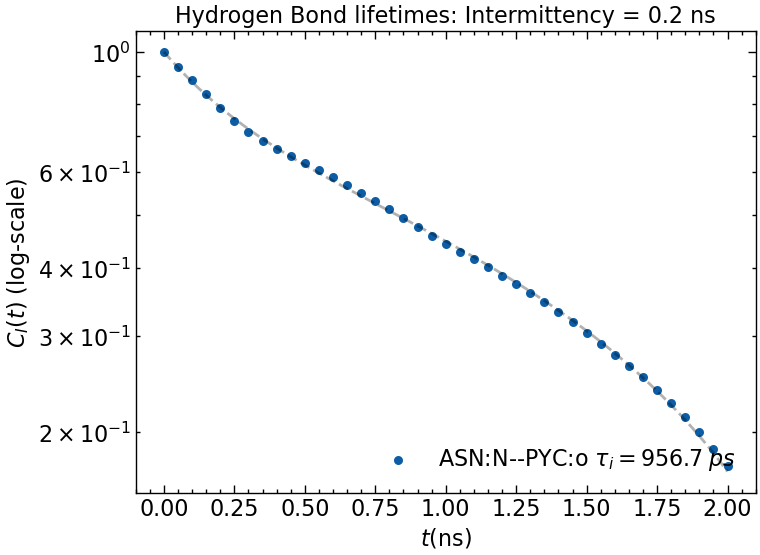

In [58]:
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt
stride = 5
# Fit exponential decay
def hbond_corr(x, A1, tau1, A2, tau2, A3, tau3):
    return A1 * np.exp(-x/tau1) + A2 * np.exp(-x/tau2) + A3 * np.exp(-x/tau3)

intermittency_time = intermittency * u.trajectory.dt/1000
plt.title(f"Hydrogen Bond lifetimes: Intermittency = {intermittency_time} ns")


# Plot the lifetimes
for hbond, hbl in hbond_lifetimes:
    d, a, _ = hbond.flatten()
    taus, hbl = hbl[:, 0], hbl[:, 1]
    times = taus * u.trajectory.dt/1000
    try:
        popt, pcov = curve_fit(hbond_corr, times, hbl, p0=[0.5, 10, 0.5, 20, 0.1, 30], maxfev=8000)
        fit_times = np.linspace(times[0], times[-1], 100)
        fit_hbl = hbond_corr(fit_times, *popt)
        tau_i, tau_err = quad(hbond_corr, fit_times[0], fit_times[-1], args=tuple(popt))
        tau_i_ps = round(1000 * tau_i, 1) if tau_i < 1 else round(tau_i) 
        if tau_i_ps > 50:
            plt.plot(fit_times, fit_hbl, color='black', ls='--', lw=2, alpha=0.3)
            plt.scatter(times[::stride], hbl[::stride], label= f'{d}--{a}' + fr' $\tau_i = {tau_i_ps}\; ps$', lw=2, s=20)
    except RuntimeError as e:
        print(f"Exception: {e}")
        plt.scatter(times[::stride], hbl[::stride], lw=2, s=20)
        continue
    

plt.xlabel(r"$t \rm (ns)$")
plt.ylabel(r"$C_I(t)$ (log-scale)")

plt.yscale("log")
#ax.yaxis.set_tick_params(which='minor', length=8, width=1.5)
plt.legend(ncol=2, loc="lower right")
plt.savefig("hbond_lifetimes.png", dpi=600)
plt.show()

The longest-lasting bond is $ASN174: N-H \cdots O$, with a lifetime of around $1\; ns$. All other bonds are less than $50\; ps$ in lifetime.


## Plots

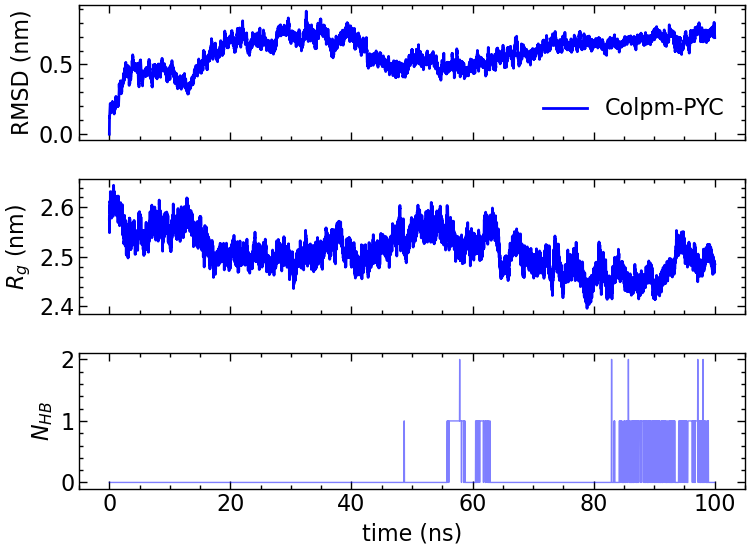

In [59]:
npanels = 3
fig, axs = plt.subplots(npanels,1, sharex=True, tight_layout=True)

ax_rmsd = axs[0]
ax_rmsd.set_ylabel(r'RMSD (nm)');


ax_rmsd.plot(times_c/1000, rmsd_c/10, label="Colpm-PYC", 
        color='blue')

ax_rmsd.legend()

ax_rg = axs[1]

ax_rg.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10, 
        label="Colpm-PYC", color='blue')
ax_rg.set_ylabel(r'$R_g$ (nm)');

ax_bonds = axs[2]
ax_bonds.set_xlabel(r'time (ns)');

ax_bonds.plot(timestep * np.arange(nframes), num_hbonds, lw=1, label="Colpm-PYC", alpha=0.5,color='blue')


ax_bonds.set_ylabel(r"$N_{HB}$")
plt.savefig("time-series-plots.png", dpi=600)
plt.show()

## Principal Component Analysis 

We will do the PCA using `gromacs` tools. Tentative comparison yields quantitatively better results for `gromacs` than `MDAnalysis`.

***Notabene*** MUST USE BACKBONE AND LIGAND AS SELECTIONS, SINCE WE NEED TO LOOK AT LIGAND CONFORMATIONAL CHANGES AS WELL.


### PCA via GROMACS tools

Go to the `sys_prod` directory, then create an index for backbone, ligand 

`gmx make_ndx -f prod_colpkm_pyc_complex.gro -o prod_colpm_pyc_complex_pca.ndx` Choose backbone OR PYC

Then, we need to dump the first frame of MD simulation as pdb file (unless that has already been done).

Then, generating the eigenvectors

`gmx covar -s start.pdb -f prod_colpm_pyc_complex_compact_compact.xtc -o prod_colpm_pyc_complex_eigenvalues.xvg -v prod_colpm_pyc_complex_eigenvectors.trr -xpma prod_colpm_pyc_complex_covapic.xpm -n prod_colpm_pyc_complex_pca.ndx`


Selections should be the index just created.

Followed by `gmx anaeig` to generate pc1, pc2 and pc3 files

`gmx anaeig -f prod_colpm_pyc_complex_compact_compact.xtc -s start.pdb -v prod_colpm_pyc_complex_eigenvectors.trr -last 1 -proj prod_colpm_pyc_complex_pc1.xvg -n prod_colpm_pyc_complex_pca.ndx`

`gmx anaeig -f prod_colpm_pyc_complex_compact_compact.xtc -s start.pdb -v prod_colpm_pyc_complex_eigenvectors.trr -first 2 -last 2 -proj prod_colpm_pyc_complex_pc2.xvg -n prod_colpm_pyc_complex_pca.ndx`

`gmx anaeig -f prod_colpm_pyc_complex_compact_compact.xtc -s start.pdb -v prod_colpm_pyc_complex_eigenvectors.trr -first 3 -last 3 -proj prod_colpm_pyc_complex_pc3.xvg -n prod_colpm_pyc_complex_pca.ndx`


Use these three xvg files (`prod_colpm_pyc_complex_pc{1,2,3}.xvg`) to generate the following plots.

In [68]:
import numpy as np

# Function to read XVG file with skip header option
def read_xvg(file_path, skip_header):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines[skip_header:]:
            if '&' in line:
                break
            else:
                data.append([float(val) for val in line.split()])
    data = np.array(data)
    return data[:, 0], data[:, 1]

# File paths for RMSD and radius of gyration XVG files
pc1_file = 'colpm_pyc_complex/sys_prod/prod_colpm_pyc_complex_pc1.xvg'
pc2_file = 'colpm_pyc_complex/sys_prod/prod_colpm_pyc_complex_pc2.xvg'
pc3_file = 'colpm_pyc_complex/sys_prod/prod_colpm_pyc_complex_pc3.xvg'

# Read data from XVG files with skip headers
t1, pc1_data = read_xvg(pc1_file, skip_header=24)  # Adjust skip_header based on your file format
t2, pc2_data = read_xvg(pc2_file, skip_header=24)  # Adjust skip_header based on your file format
t2, pc3_data = read_xvg(pc3_file, skip_header=24)  # Adjust skip_header based on your file format

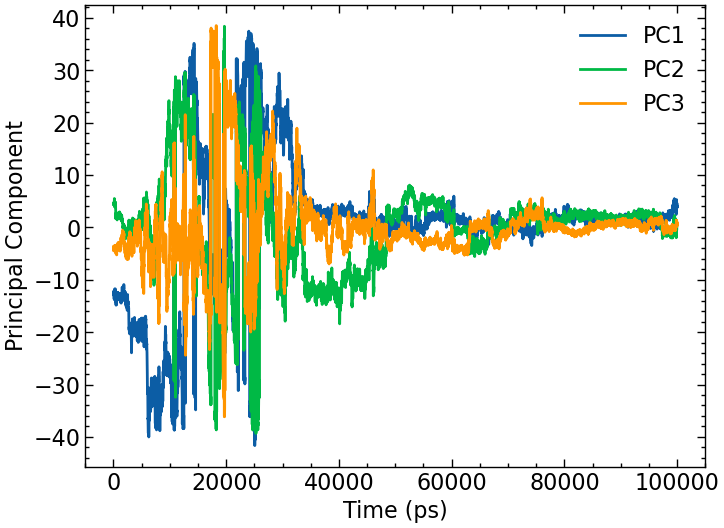

In [69]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])
plt.plot(t1, pc1_data, label='PC1')
plt.plot(t2, pc2_data, label='PC2')
plt.plot(t2, pc3_data, label='PC3')
plt.xlabel('Time (ps)')
plt.ylabel('Principal Component')
plt.legend()

For PCA with respect to energy, first

```bash
paste prod_colpm_pyc_complex_pc1.xvg prod_colpm_pyc_complex_pc2.xvg | awk '{print $1, $2, $4}' > prod_colpm_pyc_complex_pc1pc2.xvg

paste prod_colpm_pyc_complex_pc2.xvg prod_colpm_pyc_complex_pc3.xvg | awk '{print $1, $2, $4}' > prod_colpm_pyc_complex_pc2pc3.xvg

paste prod_colpm_pyc_complex_pc3.xvg prod_colpm_pyc_complex_pc1.xvg | awk '{print $1, $2, $4}' > prod_colpm_pyc_complex_pc3pc1.xvg
```

Then, use these PCIPCJ.xvg files to generate xpm files

```bash

gmx sham -f prod_colpm_pyc_complex_pc1pc2.xvg -ls prod_colpm_pyc_complex_FES12.xpm
gmx sham -f prod_colpm_pyc_complex_pc2pc3.xvg -ls prod_colpm_pyc_complex_FES23.xpm
gmx sham -f prod_colpm_pyc_complex_pc3pc1.xvg -ls prod_colpm_pyc_complex_FES31.xpm

```

Then use the following `xpm2txt.py` script to convert the .xpm file into .dat file:


In [ ]:
%%script true
#!/usr/bin/env python3

import sys

"""
Utility tool to convert xpm files generated by GROMACS to a 3-column text file.
"""

USAGE = "USAGE: xpm2txt.py -f <input xpm file> -o <output txt file> [-s]\n"
USAGE += "Options:\n"
USAGE += "\t-s\t(int)\tSorts the output by a given column"
USAGE += "\n"  # always keep this line

# Parse arguments
read_input, read_output, sort = False, False, False
xpm_file, out_file, column_sort = None, None, None
for arg in sys.argv[1:]:
    if read_input:
        read_input = False
        xpm_file = arg
    elif read_output:
        read_output = False
        out_file = arg
    elif sort:
        sort = False
        column_sort = int(arg)
    if arg.startswith("-"):
        if arg == "-f":
            read_input = True
            continue
        elif arg == "-o":
            read_output = True
            continue
        elif arg == "-s":
            sort = True
        else:
            print(USAGE)
            sys.stderr.write('ERROR: Option not recognized: %s\n' % arg)
            sys.exit(1)

if not xpm_file:
    print(USAGE)
    sys.stderr.write('ERROR: You forgot to provide an input file.\n')
    sys.exit(1)
if not out_file:
    out_file = "out.txt"

# Parse XPM file
with open(xpm_file) as xpm_handle:
    xpm_data = []
    x_axis, y_axis = [], []
    letter_to_value = {}
    for line in xpm_handle:
        if line.startswith("/* x-axis"):
            x_axis = list(map(float, line.split()[2:-2]))  # We trim the last value

        if line.startswith("/* y-axis"):
            y_axis = list(map(float, line.split()[2:-2]))  # We trim the last value

        if line.startswith('"') and x_axis and y_axis:  # Read data
            xpm_data.insert(0, line.strip().strip(',')[1:-1])

        if line.startswith('"') and len(line.split()) > 4:
            letter = line.split()[0][1:]
            value = float(line.split()[-2][1:-1])
            letter_to_value[letter] = value

# Match x/y/data
txt_values = []
for y_index, data_value in enumerate(xpm_data):
    y_value = y_axis[y_index]
    for x_index, x_value in enumerate(x_axis):
        txt_values.append([x_value, y_value, letter_to_value[data_value[x_index]]])

# Apply sorting if requested
if column_sort:
    try:
        txt_values.sort(key=lambda x: x[column_sort - 1])
    except IndexError:
        print(USAGE)
        sys.stderr.write('ERROR: Column not found (%s)\n' % (column_sort))
        sys.exit(1)

# Print to file
with open(out_file, 'w') as out_handle:
    for x, y, z in txt_values:
        out_handle.write("%3.5f\t%3.5f\t%3.5f\n" % (x, y, z))

Use this above-mentioned script as

```bash
./xpm2txt.py -f prod_colpm_pyc_complex_FES12.xpm -o prod_colpm_pyc_complex_FEL12.dat
./xpm2txt.py -f prod_colpm_pyc_complex_FES23.xpm -o prod_colpm_pyc_complex_FEL23.dat
./xpm2txt.py -f prod_colpm_pyc_complex_FES31.xpm -o prod_colpm_pyc_complex_FEL31.dat
```

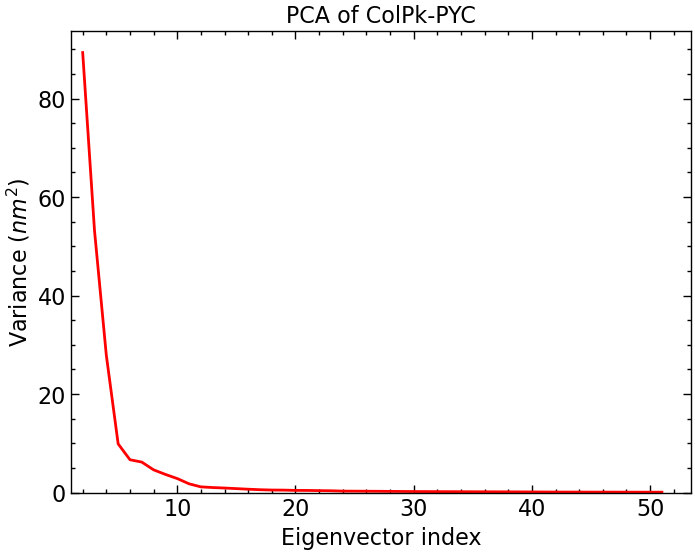

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Read input data from a file
input_file = 'colpm_pyc_complex/sys_prod/prod_colpm_pyc_complex_FEL12.dat'
data = np.loadtxt(input_file)  # Assuming input data file ha6s PC1, PC2, and hbonds columns

PC12_1 = data[:, 0]
PC12_2 = data[:, 1]
free_energy_12 = data[:, 2]/4.184  # Convert kJ/mol to kcal/mol


input_file = 'colpm_pyc_complex/sys_prod/prod_colpm_pyc_complex_FEL23.dat'
data = np.loadtxt(input_file)  # Assuming input data file ha6s PC1, PC2, and hbonds columns

PC23_2 = data[:, 0]
PC23_3 = data[:, 1]
free_energy_23 = data[:, 2]/4.184  # Convert kJ/mol to kcal/mol

input_file = 'colpm_pyc_complex/sys_prod/prod_colpm_pyc_complex_FEL31.dat'
data = np.loadtxt(input_file)  # Assuming input data file ha6s PC1, PC2, and hbonds columns

PC31_3 = data[:, 0]
PC31_1 = data[:, 1]
free_energy_31 = data[:, 2]/4.184  # Convert kJ/mol to kcal/mol


# Function to read XVG file and extract data
def read_xvg(file_path):
    data = np.genfromtxt(file_path, skip_header=18)  # Adjust skip_header based on your XVG file format
    xpoints = data[:, 0]
    ypoints = data[:, 1]
    return xpoints, ypoints

# Replace these placeholders with your actual file paths
D1_path = 'colpm_pyc_complex/sys_prod/prod_colpm_pyc_complex_eigenvalues.xvg'

# Read data from XVG files
time_D1, D1_data = read_xvg(D1_path)

plt.plot(time_D1[0:50], D1_data[0:50], color='red')
plt.xlim(1, )
plt.ylim(0, )
plt.xlabel('Eigenvector index')
plt.ylabel(r'Variance $\left(nm^2\right)$')
plt.title('PCA of ColPk-PYC');
plt.savefig("pca-colpk-pyc.png", dpi=600)


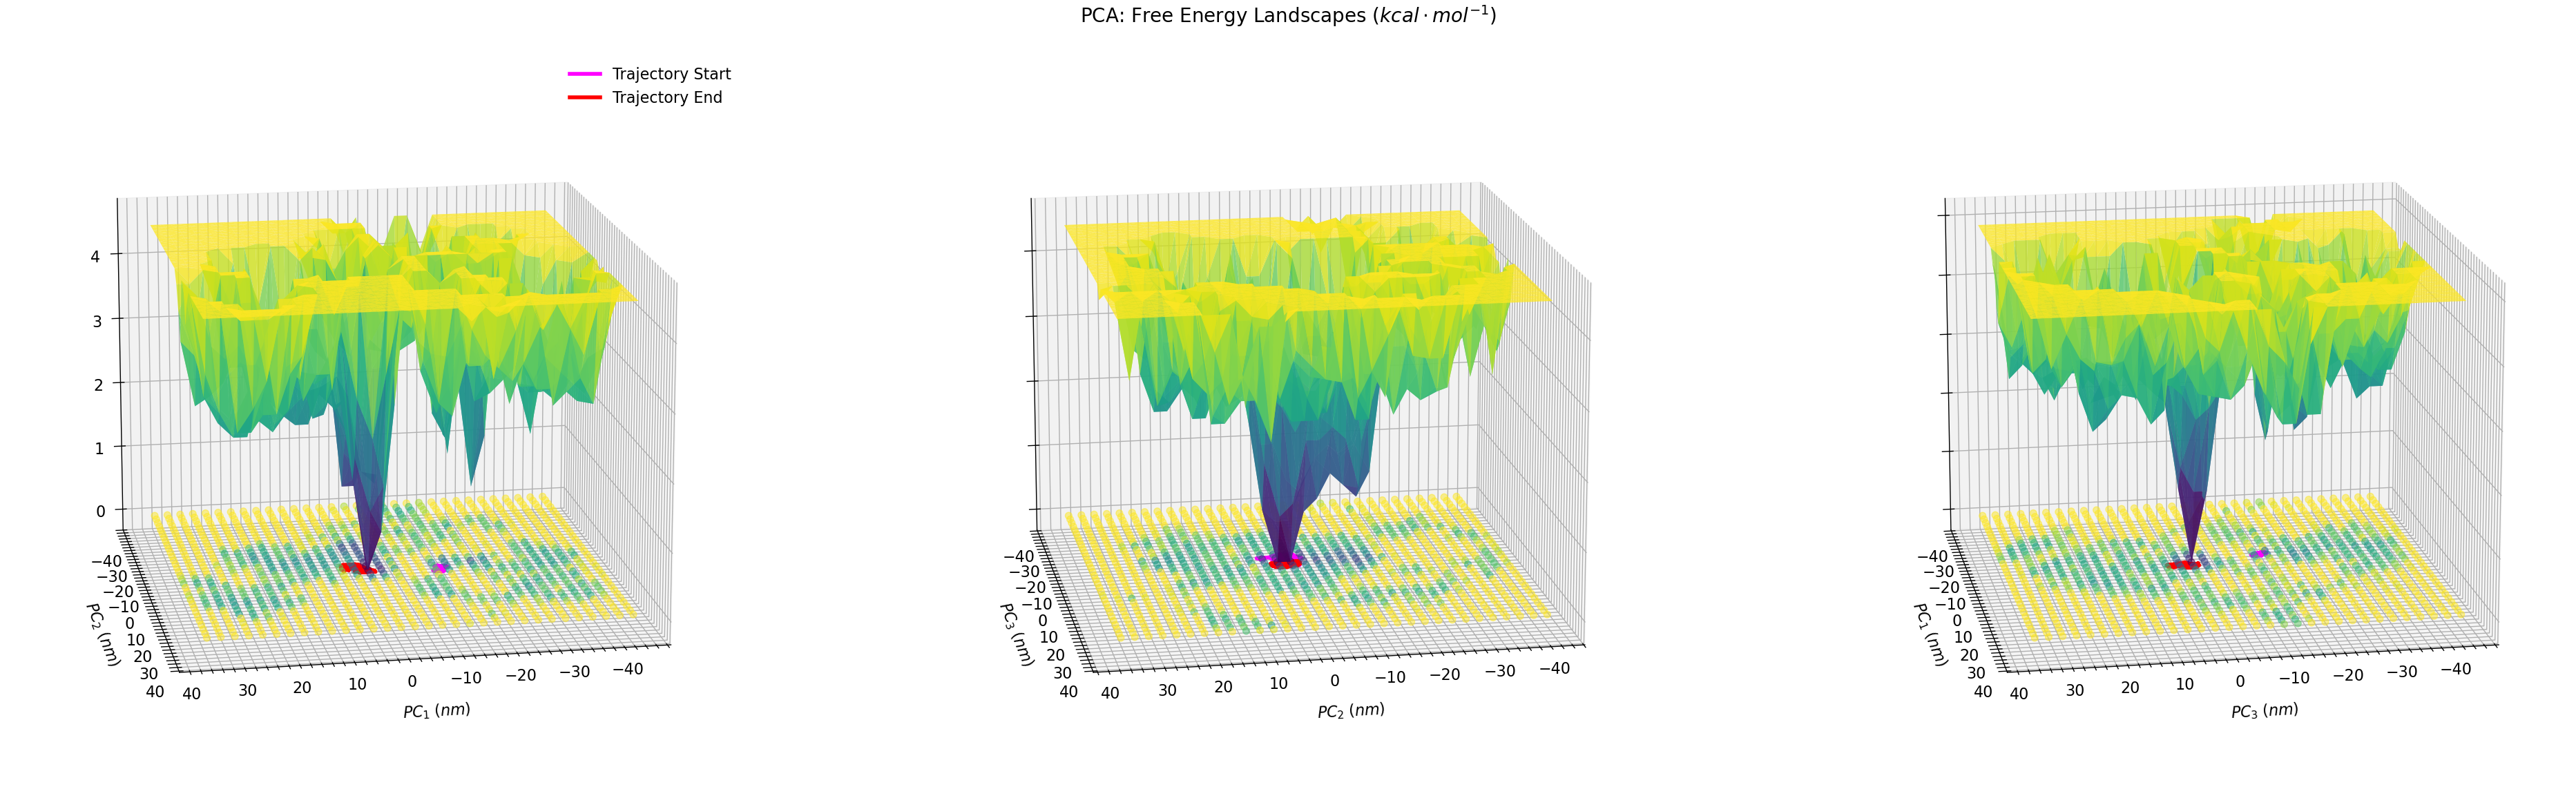

In [84]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scienceplots

import matplotlib.pyplot as plt

plt.style.use(['science','notebook'])
fig = plt.figure(figsize=(40, 12))
fig.suptitle(r'PCA: Free Energy Landscapes $\left(kcal\cdot mol^{-1}\right)$', fontsize=20)
# First subplot: free_energy_12 vs PC12
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.plot_trisurf(PC12_1, PC12_2, free_energy_12, cmap='viridis', alpha=0.8)
ax1.set_xlabel(r'$PC_1\; (nm)$', labelpad=20)
ax1.set_ylabel(r'$PC_2\;(nm)$', labelpad=20)
ax1.scatter(PC12_1, PC12_2, c=free_energy_12, cmap='viridis', s=50, alpha=0.5)
ax1.plot(pc1_data[0:100], pc2_data[0:100], 0, color='magenta', linewidth=4, label='Trajectory Start')
ax1.plot(pc1_data[-1000:-1], pc2_data[-1000:-1], 0, color='red', linewidth=4, label='Trajectory End')
ax1.legend()

# Second subplot: free_energy_23 vs PC23
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.plot_trisurf(PC23_2, PC23_3, free_energy_23, cmap='viridis', alpha=0.8)
ax2.set_xlabel(r'$PC_2\; (nm)$', labelpad=20)
ax2.set_ylabel(r'$PC_3\; (nm)$', labelpad=20)
ax2.scatter(PC23_2, PC23_3, c=free_energy_23, cmap='viridis', s=50, alpha=0.5)
ax2.plot(pc2_data[0:500], pc3_data[0:500], 0, color='magenta', linewidth=4, label='Trajectory Start')
ax2.plot(pc2_data[-1000:-1], pc3_data[-1000:-1], 0, color='red', linewidth=4, label='Trajectory End')

# Third subplot: free_energy_31 vs PC31
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.plot_trisurf(PC31_1, PC31_3, free_energy_31, cmap='viridis', alpha=0.8)
ax3.set_xlabel(r'$PC_3\; (nm)$', labelpad=20)
ax3.set_ylabel(r'$PC_1\; (nm)$', labelpad=20)
ax3.scatter(PC31_1, PC31_3, c=free_energy_31, cmap='viridis', s=50, alpha=0.5)
ax3.plot(pc1_data[0:100], pc3_data[0:100], 0, color='magenta', linewidth=4, label='Trajectory Start')
ax3.plot(pc1_data[-1000:-1], pc3_data[-1000:-1], 0, color='red', linewidth=4, label='Trajectory End')

for ax in [ax1, ax2, ax3]:
    ax.view_init(elev=15, azim=80)
    ax.yaxis.set_tick_params(pad=10)

ax1.zaxis.set_tick_params(pad=10)
ax2.set_zticklabels([])
ax3.set_zticklabels([])
plt.savefig("pca-free-energy.png", dpi=600)
plt.tight_layout()
plt.show()

### PCA Conclusion

**TODO**

Finally, I ran the following commands to project the trajectory to the PCA components and then visualize them.

`gmx anaeig -f prod_colpm_pyc_complex_compact_compact.xtc -s start.pdb -extr extreme_pc.pdb -first 1 -last 3 -n prod_colpm_pyc_complex_pca.ndx -nframes 80 -v prod_colpm_pyc_complex_eigenvectors.trr`

Then load the three pdbs of the projetions along each axis into pymol and made the following observations. Along all projections, the tail beginning of the protein seems to 'whip about' a bit, suggesting a possible **conformational change** that might cause the shifts from one valley to another in the free energy landscape above.


In [ ]:
from IPython.display import Image
Image("pc1pc2pc3.png")

### TODO

Vander-waals and hydrophobic interactions.